Building the following trading simulation.

You can trade three stocks: Apple, Coca-Cola, and IBM.

Your portfolio is rebalanced every week and held for a week.

At the beginning of each week, you make a decision to adjust your portfolio holding based on the following state variables: last week's return on these 3 stocks and your current holding on these three stocks.

Your simulation (episode) starts in the beginning of 2010 with an initial cash holding of 100

Your simulation (episode) terminates if the following conditions are met: your current cash holding + your current portfolio value <= 0 dollar. OR you have reached the end of the year 2017.

Your actions are to long 1 share, short 1 share, stay neutral for each stock -- your actions are three dimensional vectors.

At the end of each period, determine whether your simulation has ended by checking the date and the sum of your cash holding and portfolio value. The portofolio value is the sum of the value of the three stocks in your portfolio based on how many shares you hold.

When you commit an action, the immediate reward is the gain of the shares sold (shorted) minus the cost of the number of shares bought. We ignore the transaction cost here. When you reach the end, you receive an additional reward that is equal to the value of your portfolio at the end.

First build this experiment, and then plot the trajectory of your networth: cash+portfolio value over time under a random policy (randomly choosing actions at each state). Use a random state of 123. Assume no discounting. Use the data from Yahoo Finance.

In [53]:
# Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from typing import List, Tuple, Callable

In [42]:
# Set random seed for reproducibility
np.random.seed(123)

# Download historical data from Yahoo Finance
start_date = "2010-01-01"
end_date = "2017-12-31"
tickers = ["AAPL", "KO", "IBM"]
data = yf.download(tickers, start=start_date, end=end_date)

test_data = yf.download(tickers, start='2018-01-01', end='2018-12-31')

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


## Data Viz

In [43]:
def plot_adjusted_close_prices(data, tickers):
    """
    Plots the adjusted close prices of each stock over time.
    
    Args:
    data (pd.DataFrame): The DataFrame containing stock data.
    tickers (list): List of ticker symbols for the stocks.
    """
    plt.figure(figsize=(14, 7))
    
    start_date = data.index.min().strftime('%Y-%m-%d')
    end_date = data.index.max().strftime('%Y-%m-%d')

    for ticker in tickers:
        plt.plot(data.index, data['Adj Close', ticker], label=ticker)

    plt.title(f'Adjusted Close Price of Stocks ({start_date} to {end_date})')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


def plot_normalized_adjusted_close_prices(data, tickers):
    """
    Plots normalized adjusted close prices of each stock over time, starting at 100.
    
    Args:
    data (pd.DataFrame): The DataFrame containing stock data.
    tickers (list): List of ticker symbols for the stocks.
    """
    normalized_data = data['Adj Close'].copy()
    normalized_data = normalized_data / normalized_data.iloc[0] * 100

    plt.figure(figsize=(14, 7))
    
    start_date = normalized_data.index.min().strftime('%Y-%m-%d')
    end_date = normalized_data.index.max().strftime('%Y-%m-%d')

    for ticker in tickers:
        plt.plot(normalized_data.index, normalized_data[ticker], label=ticker)

    plt.title(f'Normalized Adjusted Close Price of Stocks ({start_date} to {end_date})')
    plt.xlabel('Date')
    plt.ylabel('Normalized Adjusted Close Price (Starting at 100)')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


def plot_trading_volume(data, tickers):
    """
    Plots the trading volume of each stock over time.
    
    Args:
    data (pd.DataFrame): The DataFrame containing stock data.
    tickers (list): List of ticker symbols for the stocks.
    """
    plt.figure(figsize=(14, 7))
    
    start_date = data.index.min().strftime('%Y-%m-%d')
    end_date = data.index.max().strftime('%Y-%m-%d')

    for ticker in tickers:
        plt.plot(data.index, data['Volume', ticker], label=ticker)

    plt.title(f'Trading Volume of Stocks ({start_date} to {end_date})')
    plt.xlabel('Date')
    plt.ylabel('Volume Traded')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


def plot_candlestick_chart(data, tickers):
    """
    Plots a candlestick chart for each stock.
    
    Args:
    data (pd.DataFrame): The DataFrame containing stock data.
    tickers (list): List of ticker symbols for the stocks.
    """
    for ticker in tickers:
        data_candle = data[['Open', 'High', 'Low', 'Close']].loc[:, (slice(None), ticker)]
        data_candle.columns = data_candle.columns.droplevel(1)
        
        start_date = data_candle.index.min().strftime('%Y-%m-%d')
        end_date = data_candle.index.max().strftime('%Y-%m-%d')

        mpf.plot(
            data_candle,
            type='candle',
            style='charles',
            title=f'Candlestick Chart for {ticker} ({start_date} to {end_date})',
            ylabel='Price ($)',
            figratio=(14, 7),
            figscale=1.2
        )

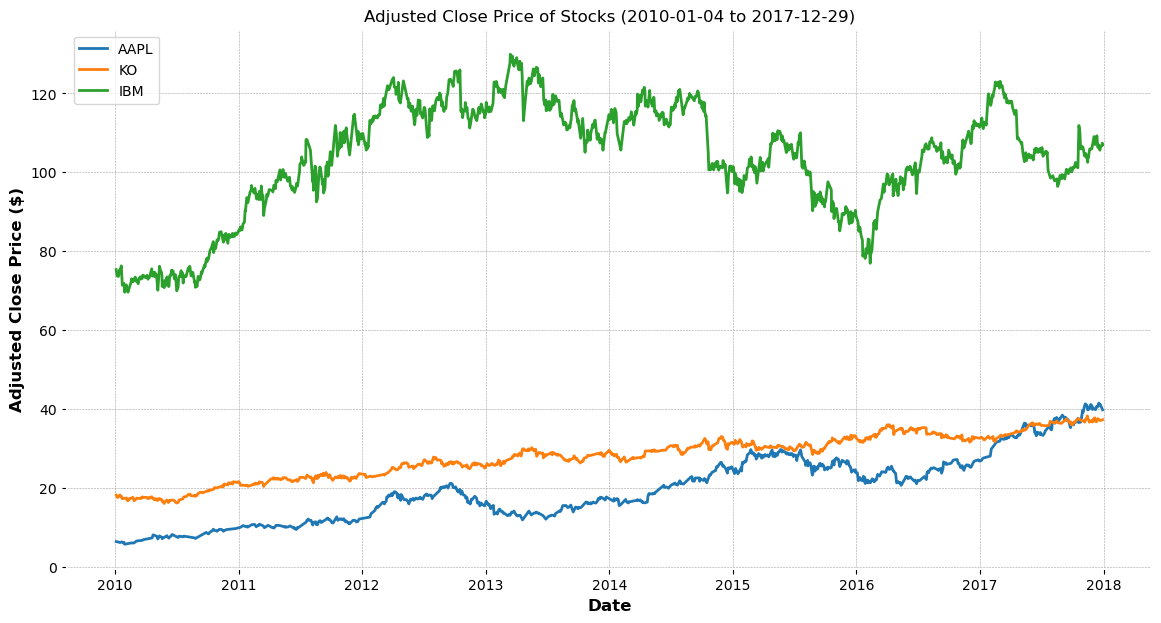

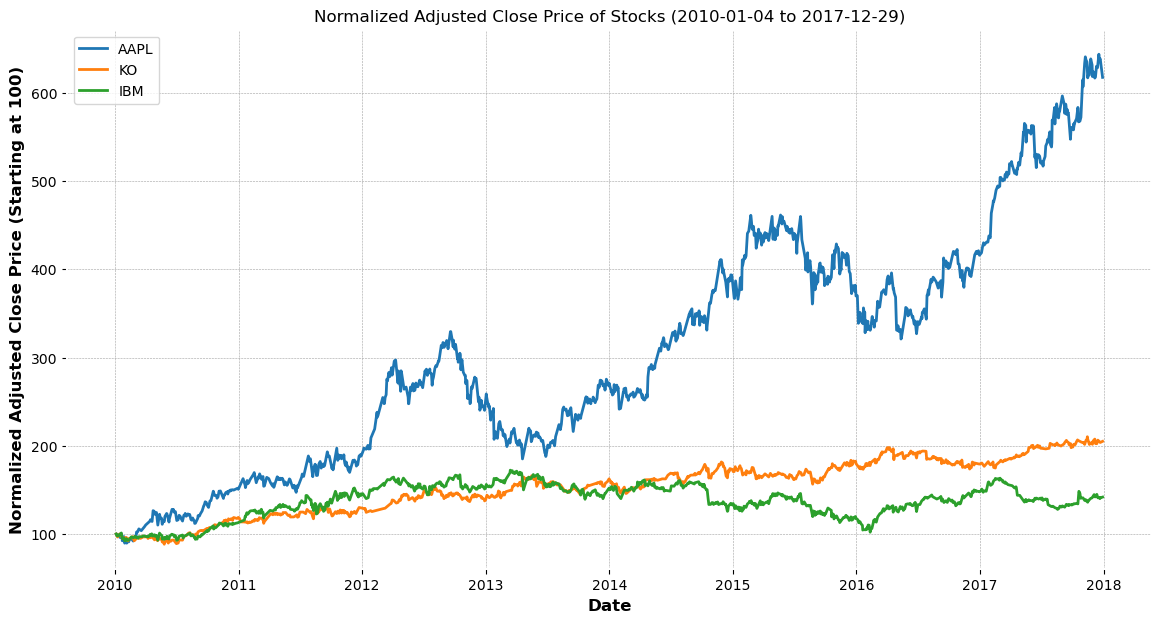

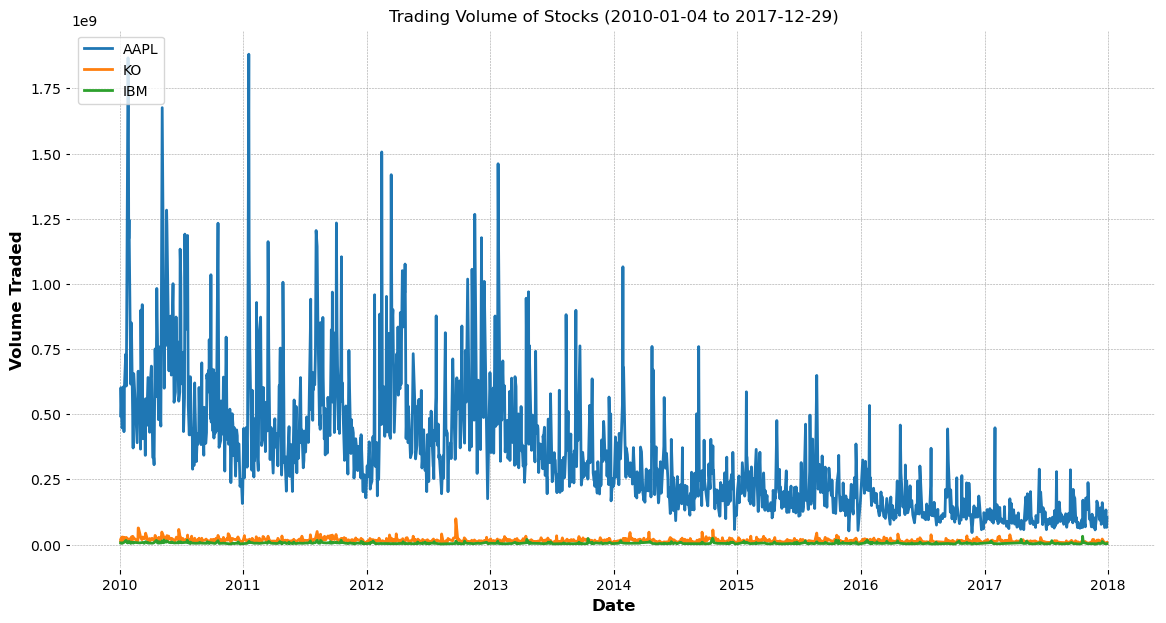

In [45]:
plot_adjusted_close_prices(data, tickers)
plot_normalized_adjusted_close_prices(data, tickers)
plot_trading_volume(data, tickers)
# plot_candlestick_chart(data, tickers)

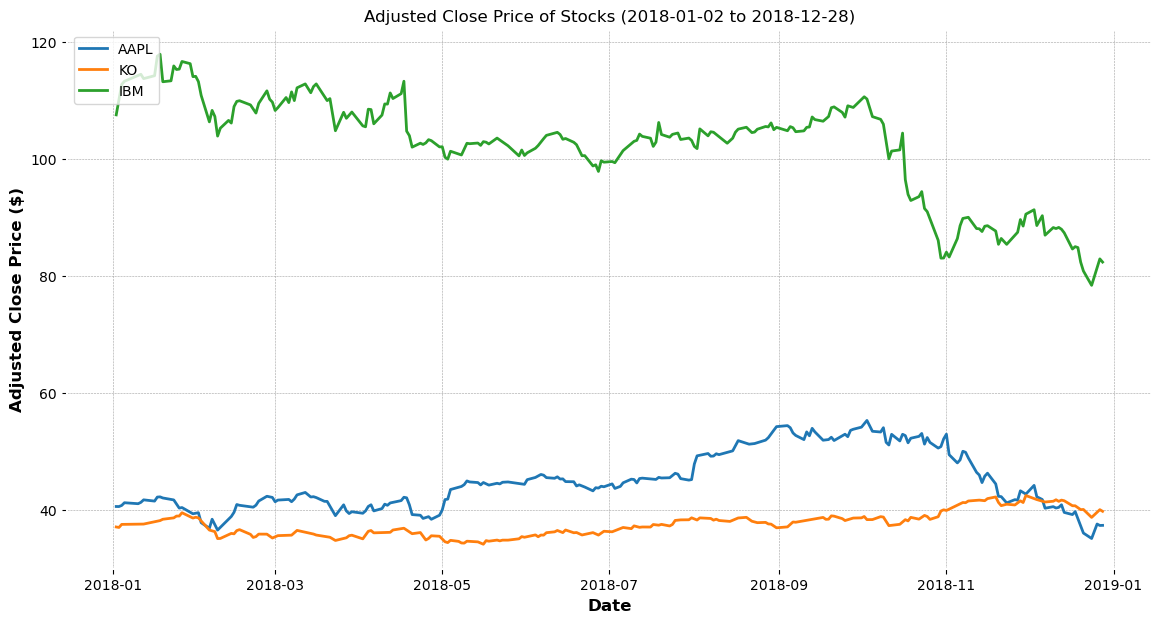

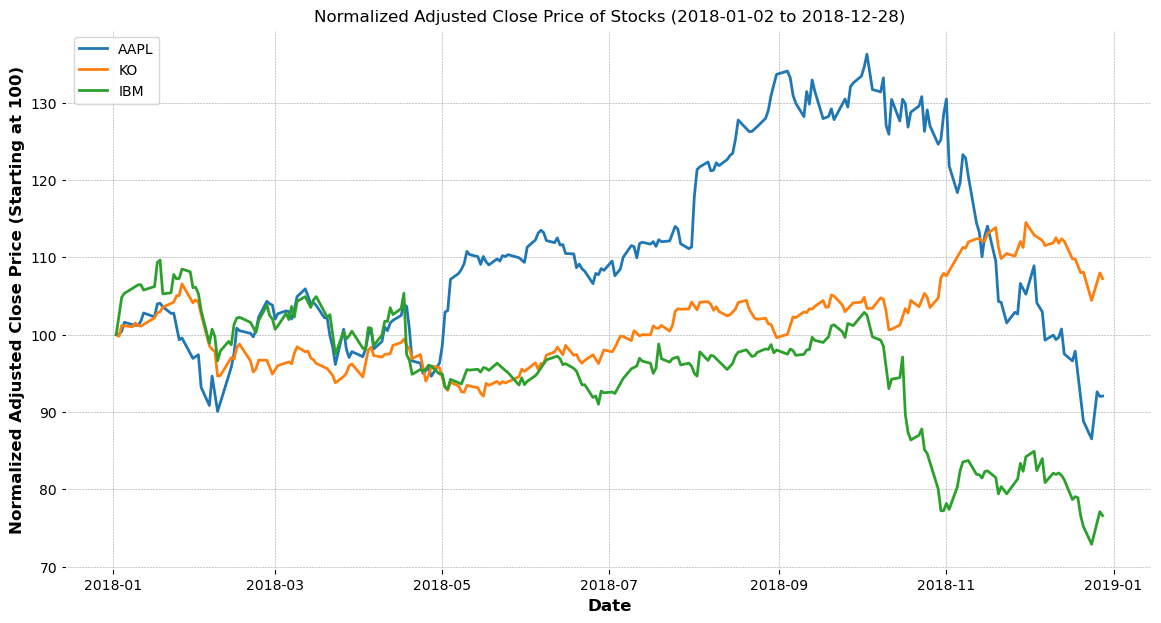

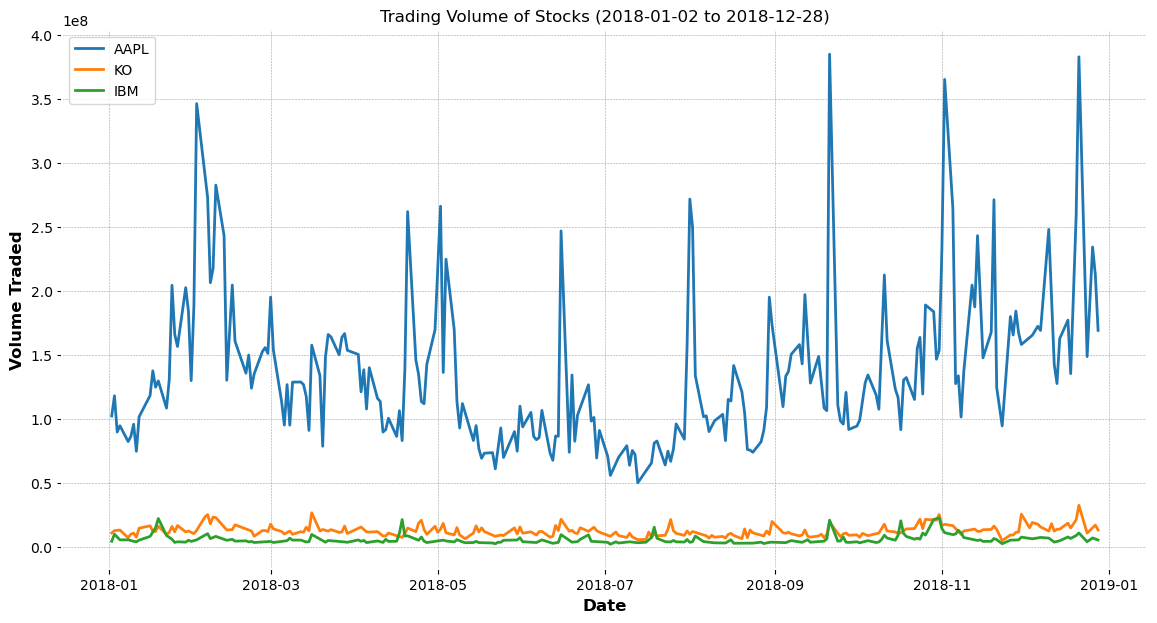

In [47]:
plot_adjusted_close_prices(test_data, tickers)
plot_normalized_adjusted_close_prices(test_data, tickers)
plot_trading_volume(test_data, tickers)
# plot_candlestick_chart(test_data, tickers)

In [48]:
# Initialize the environment
initial_cash = 100.0
cash = initial_cash
portfolio = {"AAPL": 0, "KO": 0, "IBM": 0}

# Track net worth and actions over time
net_worth_history = []
actions_history = []

In [54]:
def get_portfolio_value(portfolio, prices):
    """
    Calculate the total value of the portfolio.

    Args:
    portfolio (dict): Current holdings of each stock.
    prices (pd.Series): Current prices of each stock.

    Returns:
    float: Total value of the portfolio.
    """
    value = 0
    for stock, shares in portfolio.items():
        value += shares * prices[stock]
    return value


def random_action():
    """
    Randomly choose an action for each stock: long (1), short (-1), or neutral (0).

    Returns:
    np.ndarray: Array of actions for each stock.
    """
    return np.random.choice([-1, 0, 1], size=3)


def apply_action(action, portfolio, prices, cash):
    """
    Apply action to portfolio and update cash balance.

    Args:
    action (np.ndarray): Actions for each stock.
    portfolio (dict): Current holdings of each stock.
    prices (pd.Series): Current prices of each stock.
    cash (float): Current cash balance.

    Returns:
    tuple: Updated cash balance and reward from the action.
    """
    reward = 0
    for idx, stock in enumerate(portfolio.keys()):
        shares_to_trade = action[idx]
        stock_price = prices[stock]

        # Long action: buy 1 share
        if shares_to_trade == 1:
            cash -= stock_price
            portfolio[stock] += 1
            reward -= stock_price  # Cost of buying

        # Short action: sell 1 share
        elif shares_to_trade == -1:
            cash += stock_price
            portfolio[stock] -= 1
            reward += stock_price  # Gain from selling

    return cash, reward


def run_simulation(data, tickers, initial_cash=100.0):
    """
    Run the trading simulation with random actions.

    Args:
    data (pd.DataFrame): The DataFrame containing stock data.
    tickers (list): List of ticker symbols for the stocks.
    initial_cash (float): Initial cash holding.

    Returns:
    tuple: Lists of net worth history and actions history.
    """
    cash = initial_cash
    portfolio = {ticker: 0 for ticker in tickers}

    net_worth_history = []
    actions_history = []

    for i in range(len(data) - 1):
        current_prices = data.iloc[i]
        next_prices = data.iloc[i + 1]

        # Choose a random action
        action = random_action()

        # Apply the action and calculate immediate reward
        cash, _ = apply_action(action, portfolio, current_prices, cash)

        # Calculate total portfolio value
        portfolio_value = get_portfolio_value(portfolio, next_prices)

        # Update net worth (cash + portfolio value)
        net_worth = cash + portfolio_value
        net_worth_history.append(net_worth)
        actions_history.append(action)

        # Check if the simulation should end
        if net_worth <= 0:
            print("Simulation terminated early: Net worth is zero or less.")
            break

    return net_worth_history, actions_history


def plot_simulation_results(net_worth_history, actions_history, tickers):
    """
    Plot the trajectory of net worth and trading decisions over time.

    Args:
    net_worth_history (list): List of net worth over time.
    actions_history (list): List of actions over time.
    tickers (list): List of ticker symbols for the stocks.
    """
    actions_df = pd.DataFrame(actions_history, columns=tickers)

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(net_worth_history, label="Net Worth Over Time")
    plt.xlabel("Weeks")
    plt.ylabel("Net Worth ($)")
    plt.title("Trading Simulation Net Worth Trajectory")
    plt.legend()

    # plt.subplot(2, 1, 2)
    # for ticker in tickers:
    #     plt.plot(actions_df.index, actions_df[ticker], label=f'{ticker} Action')
    # plt.xlabel("Weeks")
    # plt.ylabel("Action (-1: Sell, 0: Neutral, 1: Buy)")
    # plt.title("Trading Decisions Over Time")
    # plt.legend()
    # plt.grid(True)
    # Plot the heatmap of trading decisions
    plt.subplot(2, 1, 2)
    sns.heatmap(actions_df.T, cmap='coolwarm', cbar_kws={'label': 'Action (-1: Sell, 0: Neutral, 1: Buy)'}, center=0, annot=True, fmt="d")
    plt.xlabel("Weeks")
    plt.ylabel("Ticker")
    plt.title("Trading Decisions Heatmap Over Time")

    plt.tight_layout()
    plt.show()


In [55]:
data['Adj Close']

Ticker,AAPL,IBM,KO
Date,,,
2010-01-04,6.454505,75.353806,18.209934
2010-01-05,6.465664,74.443497,17.989651
2010-01-06,6.362821,73.959930,17.983269
2010-01-07,6.351057,73.703903,17.938578
2010-01-08,6.393282,74.443497,17.606558
...,...,...,...
2017-12-22,41.216591,106.310478,37.110126
2017-12-26,40.170925,106.540527,37.289227
2017-12-27,40.177979,106.749664,37.386883


Simulation terminated early: Net worth is zero or less.


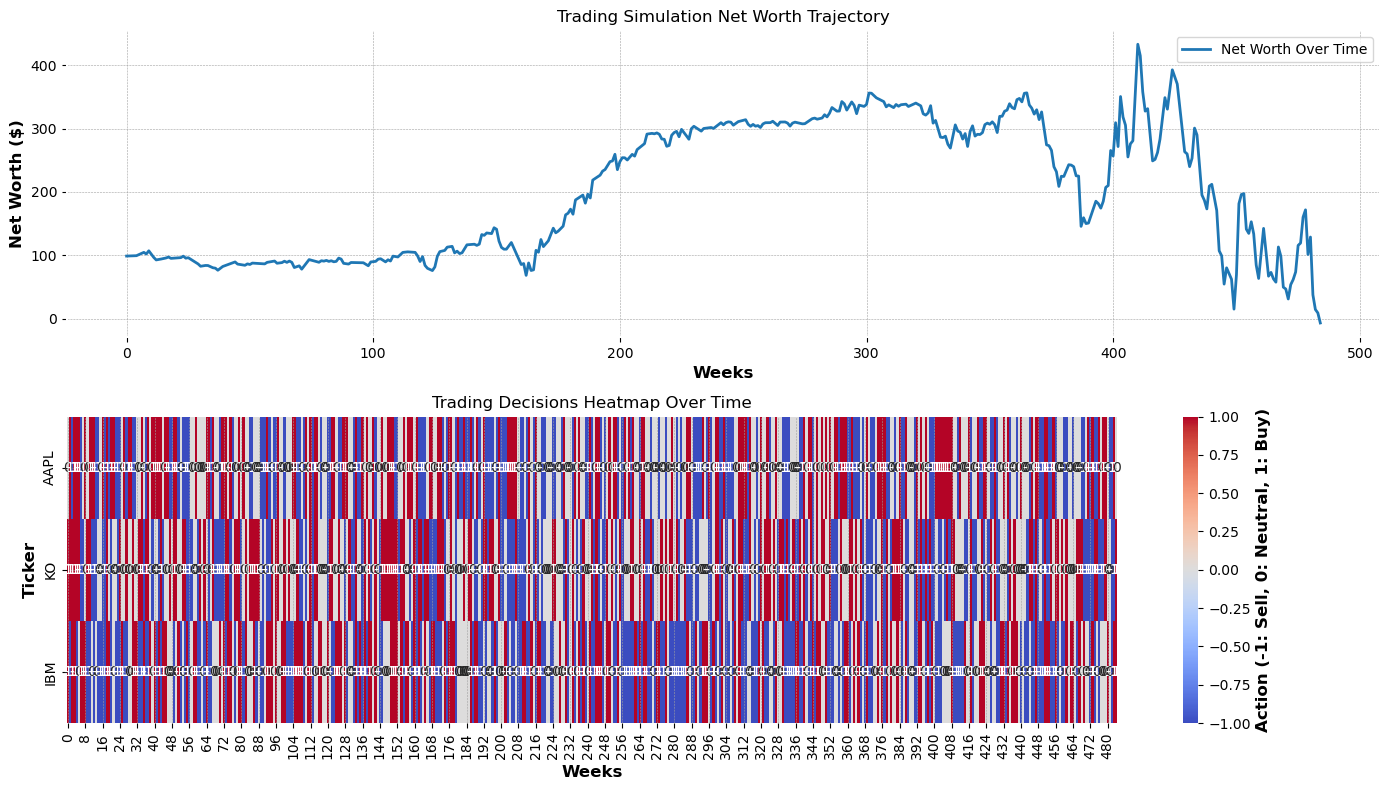

In [56]:
data_adj = data['Adj Close']

np.rand
# Step 2: Run the simulation
net_worth_history, actions_history = run_simulation(data_adj, tickers)

# Step 3: Plot the results
plot_simulation_results(net_worth_history, actions_history, tickers)

Implement a Q-learning algorithm. Start with a random policy and update the policy every 2 weeks. Tune the hyperparameters of the model you choose to estimate Q -- the objective is to maximize the total discounted reward. Do not use any data in 2018 (using any data in 2018 in this stage would disqualify this assignment). Report the total reward and also report the cash holding and portfolio value separately.

Freeze this policy. Assume you start with no stock holdings and 100 dollars in the beginning of 2018. Deploy this policy for the next month and next year. Report the total reward the policy achieves in the next month and next year, separately.

The two rewards will be ranked separately, and the ranking of the average ranking will be your overall ranking for this assignment. The tiebreaker is the total reward in the next month.